<!-- Professional Notebook Header -->
<div style="display: flex; align-items: center; justify-content: space-between; padding: 12px 10px; border-bottom: 4px solid #003366;">
  <div style="flex: 0 0 auto;">
    <img src="../../dcs_logo_small.png" alt="Department Logo" style="height:72px;">
  </div>
  <div style="text-align: center; flex-grow: 0; margin: 0 auto; font-family: 'Segoe UI', sans-serif;">
    <h1 style="margin: 0; font-size: 26px; color: #003366;">CS-866 Deep Reinforcement Learning</h1>
    <!--<h2 style="margin: 4px 0; font-size: 18px; color: #005599;">CS-866</h2>-->
    <h3 style="margin: 2px 0; font-size: 16px; color: #222;">Notebook: <b>Policy-Based RL: REINFORCE (Mountain Car)</b></h3>
    <p style="margin: 2px 0; font-size: 14px; color: #444; text-align: center;">Instructor: <b>Nazar Khan</b> &nbsp; | &nbsp; Semester: <b>Fall 2025</b></p>
  </div>
  <div style="flex: 0 0 auto;">
    <img src="../../pu_logo.png" alt="University Logo" style="height:72px;">
  </div>
</div>

---

**This notebook** is a self-contained teaching and evaluation resource for the REINFORCE policy-gradient algorithm implemented on `MontainCarContinuous-v0`. It includes: theory, fully-commented PyTorch code, training with TensorBoard logging, recording (MP4/GIF), visualizations, and an assignment + rubric for students.

In [1]:
# REINFORCE on MountainCarContinuous-v0
# produces both GIF and MP4, uses Gymnasium API (reset -> obs, info).
#
# Requirements: gymnasium, torch, numpy, matplotlib, imageio, tqdm
# Optional (for MP4): ffmpeg installed on system (imageio uses ffmpeg)

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import imageio
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tqdm import trange
import os
import math
import tempfile

In [7]:
# -----------------------------
# 0) Short explanation
# -----------------------------
# We're teaching a little "car" how to drive up a hill to reach a flag.
# The car can push left or right with a continuous force (a number between -1 and 1).
# REINFORCE is a method where the car tries many times and learns from the
# whole trip (episode) how good its choices were.
#
# We use a neural network to pick the push (action) as a random number
# from a small bell-shaped curve (Gaussian). The network learns to shift
# the bell-curve so better actions happen more often.
#
# We'll record videos (GIF + MP4) so you can watch the car learn.

In [8]:
# -----------------------------
# 1) Environment setup
# -----------------------------
env_id = "MountainCarContinuous-v0"

# Create the environment with rgb frames available for rendering
env = gym.make(env_id, render_mode="rgb_array")  # gymnasium returns frames via env.render()

# Get dimensions and bounds
state_dim = env.observation_space.shape[0]   # normally 2: position and velocity
action_dim = env.action_space.shape[0]       # continuous action dimension (should be 1 here)
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])

print(f"Environment: {env_id}")
print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
print(f"Action bounds: [{action_low}, {action_high}] (we will clip actions to this)")

Environment: MountainCarContinuous-v0
State dimension: 2, Action dimension: 1
Action bounds: [-1.0, 1.0] (we will clip actions to this)


In [9]:
# -----------------------------
# 2) Policy network (Gaussian policy)
# -----------------------------
# The network will produce the mean of the gaussian. We keep a small learnable
# log-standard-deviation so the network can tune how exploratory it is.

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        # Simple 2-layer MLP
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.mean = nn.Linear(hidden, action_dim)
        # We'll use a separate learnable parameter for log std (shared per action dim)
        # Initialized to small negative value so initial std is modest.
        self.log_std = nn.Parameter(torch.ones(action_dim) * -0.5)

    def forward(self, x):
        # x is a torch tensor of shape (state_dim,)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mean = self.mean(x)                # shape: (action_dim,)
        std = torch.exp(self.log_std)      # shape: (action_dim,)
        return mean, std

# Instantiate policy and optimizer
policy = PolicyNet(state_dim, action_dim, hidden=128)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [10]:
# -----------------------------
# 3) Helper functions: selecting actions & computing returns
# -----------------------------
def select_action(state_np):
    """
    state_np: numpy array of state (shape (state_dim,))
    Returns: clipped_action (numpy), log_prob (torch scalar)
    """
    # Convert numpy -> torch
    state = torch.tensor(state_np, dtype=torch.float32)
    mean, std = policy(state)  # both torch tensors
    # Create a normal distribution per action dimension
    dist = torch.distributions.Normal(mean, std)
    action = dist.sample()                         # sample an action (torch)
    action_clipped = torch.clamp(action, action_low, action_high)
    # Sum log_prob across action dims to get scalar log probability
    log_prob = dist.log_prob(action).sum()
    return action_clipped.detach().numpy(), log_prob

def compute_returns(rewards, gamma=0.99):
    """
    Given a list of rewards for an episode, compute discounted returns G_t.
    Then normalize returns (important for stable REINFORCE learning).
    Returns: torch tensor of shape (len(rewards),)
    """
    returns = []
    G = 0.0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    # Normalize (subtract mean, divide by std) to reduce variance
    if returns.std().item() > 1e-8:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    else:
        returns = returns - returns.mean()
    return returns

In [7]:
# -----------------------------
# 4) Training loop with early stopping & recording
# -----------------------------
# Hyperparameters (you can tweak them)
num_episodes = 2000         # upper bound on episodes
gamma = 0.99                # discount factor
render_every = 200          # record a single frame every N episodes to create animation steps
record_last_episodes = 5    # record a few full episodes after training to make better video
early_stop_window = 100     # window for computing recent average reward
early_stop_threshold = 90.0 # average reward threshold to consider solved (common for this env)
# Explanation: MountainCarContinuous gives reward ~100 for success, so ~90 is good.

# Logging structures
episode_rewards = []
recent_buffer = deque(maxlen=early_stop_window)
frames_for_gif = []        # will store a handful of frames captured periodically
frames_final_episodes = [] # will store full frames for final example episodes (for video)
scale = 0.25                # scale for reducing frame size to save RAM

# We'll use tqdm for nicer progress bar
pbar = trange(num_episodes, desc="Training episodes")

# For stability, set a manual seed (optional)
torch.manual_seed(42)
np.random.seed(42)

solved_episode = None

for episode in pbar:
    # Gymnasium reset returns (obs, info)
    state, _ = env.reset()
    done = False
    rewards = []
    log_probs = []

    # Run one full episode (until terminated or truncated)
    while not done:
        # Optionally capture a frame every so often to make a slow-motion GIF of learning
        if (episode + 1) % render_every == 0:
            try:
                frame = env.render()  # rgb array
                frame = cv2.resize(frame, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
                frames_for_gif.append(frame)
            except Exception:
                pass  # rendering might fail in headless environments; it's optional

        action, log_prob = select_action(state)  # get action & its log probability
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated or truncated)

        rewards.append(float(reward))
        log_probs.append(log_prob)

        state = next_state

    # Compute returns and policy loss
    returns = compute_returns(rewards, gamma=gamma)  # torch tensor
    # Multiply -log_prob * return for each timestep (we minimize negative objective)
    policy_loss_terms = []
    for lp, G in zip(log_probs, returns):
        # -log_prob * G (we use negative because optimizers minimize)
        policy_loss_terms.append(-lp * G)
    policy_loss = torch.stack(policy_loss_terms).sum()

    # Gradient step
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # Logging & early stopping check
    ep_reward = sum(rewards)
    episode_rewards.append(ep_reward)
    recent_buffer.append(ep_reward)

    # Update progress bar
    pbar.set_postfix({"ep_reward": f"{ep_reward:.2f}",
                      "recent_mean": f"{np.mean(recent_buffer):.2f}" if len(recent_buffer)>0 else "N/A"})

    # Early stopping condition: average of last early_stop_window episodes above threshold
    if len(recent_buffer) == early_stop_window:
        recent_mean = float(np.mean(recent_buffer))
        if recent_mean >= early_stop_threshold:
            solved_episode = episode + 1
            print(f"\n🎉 Early stopping at episode {solved_episode}: recent mean = {recent_mean:.2f}")
            break

# If training ended early, record a few full episodes to show final behavior
# Record record_last_episodes full episodes (frames) for a nicer final video
for i in range(record_last_episodes):
    s, _ = env.reset()
    done = False
    episode_frames = []
    while not done:
        # collect frames for video
        try:
            frame = env.render()
            frame = cv2.resize(frame, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
            episode_frames.append(frame)
        except Exception:
            pass
        a, _ = select_action(s)
        s, r, terminated, truncated, _ = env.step(a)
        done = bool(terminated or truncated)
    frames_final_episodes.extend(episode_frames)

# If no final frames captured (headless), we still might have periodic frames_for_gif
if len(frames_final_episodes) == 0 and len(frames_for_gif) == 0:
    print("Warning: no frames were recorded (rendering may be disabled in this environment).")

# Close env
env.close()

Training episodes: 100%|█| 2000/2000 [23:29<00:00,  1.42it/s, ep_reward=-1.01, r


In [11]:
# -----------------------------
# 5) Save animations: GIF + MP4 (if possible)
# -----------------------------
# We'll attempt to save:
# - "mountaincar_reinforce_progress.gif": short GIF made from periodic frames_for_gif
# - "mountaincar_reinforce_final.mp4": MP4 made from final full episode frames (if available)
#
# If ffmpeg is unavailable, MP4 saving may fail; GIF saving with imageio should still work.

out_dir = "reinforce_videos"
os.makedirs(out_dir, exist_ok=True)

# Helper to scale frames (optional): ensure frames are uint8 arrays
def _to_uint8(frame):
    # frame might already be uint8; if floats, scale to 0..255
    if frame.dtype == np.uint8:
        return frame
    f = np.clip(frame, 0.0, 1.0)
    f = (255.0 * f).astype(np.uint8)
    return f

# 5a) Save short progress GIF if we have periodic frames
gif_path = os.path.join(out_dir, "mountaincar_reinforce_progress.gif")
if len(frames_for_gif) > 0:
    try:
        frames_uint8 = [_to_uint8(f) for f in frames_for_gif]
        # Make the GIF (speed up by setting fps)
        imageio.mimsave(gif_path, frames_uint8, fps=15)
        print(f"Saved progress GIF to: {gif_path} (frames used: {len(frames_uint8)})")
    except Exception as e:
        print("Could not save progress GIF:", e)
else:
    print("No periodic frames collected for progress GIF.")

# 5b) Save final episodes MP4/GIF using frames_final_episodes if available
final_gif_path = os.path.join(out_dir, "mountaincar_reinforce_final.gif")
final_mp4_path = os.path.join(out_dir, "mountaincar_reinforce_final.mp4")
if len(frames_final_episodes) > 0:
    frames_uint8_final = [_to_uint8(f) for f in frames_final_episodes]
    # Save final GIF
    try:
        imageio.mimsave(final_gif_path, frames_uint8_final, fps=30)
        print(f"Saved final GIF to: {final_gif_path} (frames: {len(frames_uint8_final)})")
    except Exception as e:
        print("Could not save final GIF:", e)

    # Try saving MP4 (may require ffmpeg)
    try:
        # imageio's ffmpeg writer uses plugin "ffmpeg"
        imageio.mimsave(final_mp4_path, frames_uint8_final, fps=30, codec="libx264")
        print(f"Saved final MP4 to: {final_mp4_path}")
    except Exception as e:
        print("Could not save MP4 (ffmpeg may be missing). Error:", e)
        print("Final GIF is available if created above.")
else:
    print("No full-episode frames collected for final video.")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Could not save progress GIF: Unable to allocate 6.70 GiB for an array with shape (9990, 400, 600, 3) and data type uint8
Could not save final GIF: Unable to allocate 3.35 GiB for an array with shape (4995, 400, 600, 3) and data type uint8
Could not save MP4 (ffmpeg may be missing). Error: [Errno 12] Cannot allocate memory
Final GIF is available if created above.


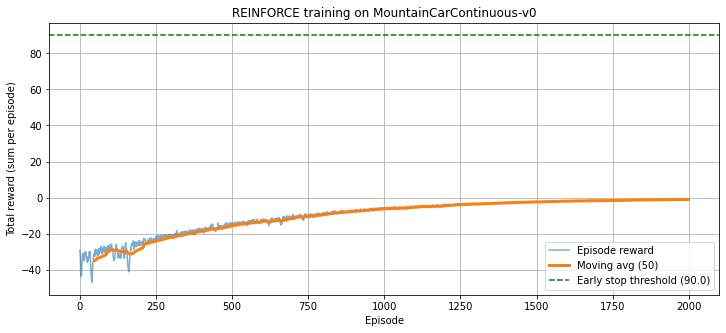


Attempting to display saved media (if any). If files are not shown, check the 'reinforce_videos' folder.
No media displayed inline. Look in the 'reinforce_videos' folder for created files.


In [9]:
# -----------------------------
# 6) Plot training curves and show animations inline (if possible)
# -----------------------------
# Plot the reward per episode and a moving average.
plt.figure(figsize=(12,5))
plt.plot(episode_rewards, alpha=0.6, label="Episode reward")
# moving average
window = 50
if len(episode_rewards) >= window:
    mov_avg = np.convolve(episode_rewards, np.ones(window)/window, mode="valid")
    plt.plot(range(window-1, window-1+len(mov_avg)), mov_avg, linewidth=3, label=f"Moving avg ({window})")
plt.axhline(early_stop_threshold, color="green", linestyle="--", label=f"Early stop threshold ({early_stop_threshold})")
plt.xlabel("Episode")
plt.ylabel("Total reward (sum per episode)")
plt.title("REINFORCE training on MountainCarContinuous-v0")
plt.legend()
plt.grid()
plt.show()

# Try to display final GIF and MP4 inline (Jupyter)
def try_display(path):
    if not os.path.exists(path):
        return False
    ext = os.path.splitext(path)[1].lower()
    if ext == ".gif":
        display(HTML(f'<img src="{path}" alt="gif">'))
        return True
    if ext == ".mp4":
        # HTML5 video tag for mp4
        display(HTML(f"""
        <video width="640" height="480" controls>
          <source src="{path}" type="video/mp4">
        Your browser does not support the video tag.
        </video>
        """))
        return True
    return False

print("\nAttempting to display saved media (if any). If files are not shown, check the 'reinforce_videos' folder.")
shown = False
# Prefer final mp4 then final gif then progress gif
if try_display(final_mp4_path):
    shown = True
elif try_display(final_gif_path):
    shown = True
elif try_display(gif_path):
    shown = True

if not shown:
    print("No media displayed inline. Look in the 'reinforce_videos' folder for created files.")

In [10]:
# -----------------------------
# 7) Short tips & next steps (printed for the user)
# -----------------------------
print("\nDone running training cell.")
if solved_episode is not None:
    print(f"Environment considered solved at episode {solved_episode} (avg >= {early_stop_threshold}).")
else:
    print("Training finished without meeting early-stop threshold. You can:")
    print("- Increase num_episodes")
    print("- Try lowering the learning rate or increasing network size")
    print("- Use a baseline (actor-critic) for faster learning")

print("\nFiles are in the folder:", os.path.abspath(out_dir))
print("If MP4 saving failed, ensure ffmpeg is installed on your system (e.g., 'sudo apt install ffmpeg' on Ubuntu).")


Done running training cell.
Training finished without meeting early-stop threshold. You can:
- Increase num_episodes
- Try lowering the learning rate or increasing network size
- Use a baseline (actor-critic) for faster learning

Files are in the folder: /home/nazar/teaching/CS866/notebooks/Reinforce/reinforce_videos
If MP4 saving failed, ensure ffmpeg is installed on your system (e.g., 'sudo apt install ffmpeg' on Ubuntu).
